<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/Problem4_Transfer_Learning_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GR5242 HW04 Problem 5: Transfer learning with MobileNets**



**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:
In this homework, you will learn  two ways of implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, you can refer to the official documentations for more info if necessary.

The first part covers loading and exploring the data. The second and third part introduce two types of transfer learning.


**Import modules for later usage.**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np


print("PyTorch version: ",torch.__version__)

PyTorch version:  2.8.0+cu126


In [2]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


## **Part 1: Introduction, Exploration**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the dataset from `torchvision`.

During the pre-processing stage, we would like to format all the images for the MobileNet module.

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [3]:
# Initialize some parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Define data transformations
transform = transforms.Compose([
    #do not restrain dim1 == dim2 == 224 here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #Custom transform to permute the dimensions
    #data is (3, dim1, dim2), we want (dim1, dim2, 3)
    #transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

from torchvision.datasets import Flowers102

# Load the dataset
# uses the built-in datase from torch, similar to that in tf
# Assuming you have PyTorch datasets, replace root=' ' with your local directory.
########## Your code here ##########
raw_train = Flowers102(root='./data', split='train', download=True, transform=transform)
raw_test = Flowers102(root='./data', split='test', download=True, transform=transform)
raw_val = Flowers102(root='./data', split='val', download=True, transform=transform)

100%|██████████| 345M/345M [00:01<00:00, 235MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.89MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 45.9MB/s]


In [4]:
#-----------------------------------------------------------
# this part is not necessary
#for nn built-in flowers


#(note that the size of the dataset does match the tf dataset)

#raw_train
print(len(raw_train))
print(len(raw_val))
print(len(raw_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = raw_train[index]

# Display the label and other information
print("nn raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.size}")

# Apply the raw data transforms to raw_train, raw_val and raw_test
train_nn = Flowers102(root='./data', split="train", download=True, transform=transform)
val_nn = Flowers102(root='./data', split="val", download=False, transform=transform)
test_nn = Flowers102(root='./data', split="test", download=True, transform=transform)

#for nn build-in flowers: raw_train
print(len(train_nn))
print(len(val_nn))
print(len(test_nn))

sample_image, label = train_nn[100]
# Display the label and other information
print("nn standardized image data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

1020
1020
6149
nn raw data
Data at index 10:
Label: 1
Image shape: <built-in method size of Tensor object at 0x7803f0134690>
1020
1020
6149
nn standardized image data
Data at index 10:
Label: 10
Image shape: torch.Size([3, 224, 224])


### (2) Data exploration

In [5]:
from torch.utils.data import DataLoader, Dataset
assert isinstance(train_nn, Dataset)
assert isinstance(val_nn, Dataset)
assert isinstance(test_nn, Dataset)

# Print the datasets
print(train_nn)
print(val_nn)
print(test_nn)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 6149
    Root location: ./data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


Let's plot some data.

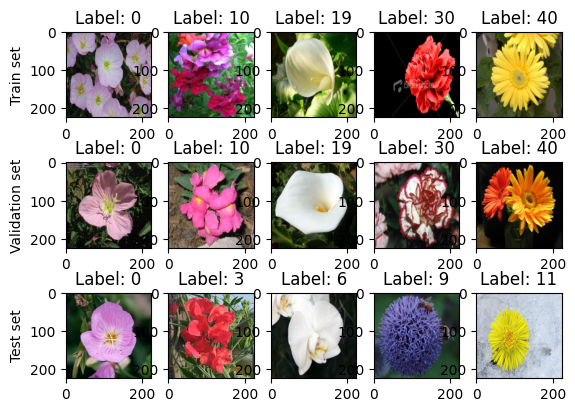

In [6]:
fig, ax = plt.subplots(3,5)
for i in range(5):  # Take example image 0,100,200,300,400
    index = i*100
    curr_f = train_nn[index][0]

    #reshape each data form (3, 224, 224) to (224, 224, 3) to plot img correctly
    reshaped_curr_f = curr_f.permute(1, 2, 0)

    curr_lab = train_nn[index][1]
    ax[0, i].set_title("Label: %d" % curr_lab)
    ax[0, i].imshow(reshaped_curr_f)
    ax[0,0].set_ylabel('Train set')

    reshaped_curr_val_f =  val_nn[index][0].permute(1, 2, 0)
    ax[1, i].set_title("Label: %d" % val_nn[index][1])
    ax[1, i].imshow(reshaped_curr_val_f)
    ax[1,0].set_ylabel('Validation set')

    reshaped_curr_test_f =  test_nn[index][0].permute(1, 2, 0)
    ax[2, i].set_title("Label: %d" % test_nn[index][1])
    ax[2, i].imshow(reshaped_curr_test_f)
    ax[2,0].set_ylabel('Test set')



### **Reflection Question (1a):**
In the data exploration stage, what is the purpose of "***assert isinstance(train, Dataset)***"?


**Your answer:**

The purpose of assert isinstance(train_nn, Dataset) is to verify that the train_nn object is indeed an instance of PyTorch's Dataset class. This serves several important purposes:

Type Safety: It ensures that the object has the expected interface and methods that we'll need later (like __len__ and __getitem__).

Error Prevention: By checking this early, we can catch potential issues before they cause confusing errors downstream in the code. If someone accidentally passed a different type of object (like a DataLoader or a raw tensor), this assertion would fail immediately and provide a clear error message.

Code Documentation: It serves as documentation for other developers (or yourself) reading the code, making it explicit what type of object is expected at this point in the pipeline.

DataLoader Compatibility: Since we'll later pass these datasets to PyTorch's DataLoader, this assertion confirms they have the correct interface that DataLoader expects.

### (3) CNN primer

Recall from the first problem, to build a neural network using `torch`, we build a class that carries out the functions of the model, define an optimizer, and iterate through a few key steps.

In this problem, we can make use of [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to save us a little hassle, now that we have seen how to build from the ground up in problem 1. When building CNNs, you can make use of the following components: [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d) for convolution filters/kernels, [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU), fully connected [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear), pooling [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), drop out [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout).

An example CNN model is given, after running the below cell, define the parameters and functions needed for training. Run through the given train/val/test pipeline.

In [7]:
# Step 1: Model definition
# Use a nn.Sequential model for defining example CNN
# Define the model using nn.Sequential, naming it model
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 32 filters, 3x3 kernel, input_shape=IMG_SHAPE
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 filters, 3x3 kernel
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64 filters, 3x3 kernel
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * (IMG_SHAPE[0] // 4) * (IMG_SHAPE[1] // 4), 128),  # Adjust input size based on IMG_SHAPE
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 102),  # Adjust output size based on the number of classes (102),
)


### **Instructions (1b)**:

Here we will prepare ourselves for training. In this stage, we outline the steps for training but do not expect performance (you should have 'some' predictive performance though). Ensure you have a trainable model with no bugs.

We need to define a few things before running our training loop, namely the `DataLoader`, `criterion`, [`optimizer`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), and [`lr_scheduler`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html).

In [8]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required

train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)
# Define your other loaders
########## Your code here ##########
val_loader_nn = DataLoader(val_nn, batch_size=32, shuffle=False)
test_loader_nn = DataLoader(test_nn, batch_size=32, shuffle=False)

# Define your loss function, naming it 'criterion'
########## Your code here ##########
criterion = nn.CrossEntropyLoss()

# Define your optimizer, 'optimizer'
########## Your code here ##########
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler, 'lr_scheduler'
########## Your code here ##########
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Let's also check if our model structure is correct by printing it
print("Model architecture:")
print(model)

# Let's verify the input/output dimensions
# Test with a single batch to ensure no shape errors
print("\nTesting model with sample batch...")
sample_batch, sample_labels = next(iter(train_loader_nn))
print(f"Input batch shape: {sample_batch.shape}")
with torch.no_grad():
    sample_output = model(sample_batch)
    print(f"Output shape: {sample_output.shape}")
    print(f"Expected output shape: [batch_size, 102]")

Model architecture:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=200704, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=102, bias=True)
)

Testing model with sample batch...
Input batch shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 102])
Expected output shape: [batch_size, 102]


### **Instructions (1c)**:

Complete the code to train the model and get the learning curves. Evaluate your model.

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: | Train Loss: 4.7727 | Train Acc: 0.78% | Val Loss: 4.6261 | Val Acc: 0.98%
Epoch 2: | Train Loss: 4.6280 | Train Acc: 1.18% | Val Loss: 4.6253 | Val Acc: 0.59%
Epoch 3: | Train Loss: 4.6255 | Train Acc: 0.69% | Val Loss: 4.6241 | Val Acc: 0.59%
Epoch 4: | Train Loss: 4.6169 | Train Acc: 0.98% | Val Loss: 4.6162 | Val Acc: 0.98%
Epoch 5: | Train Loss: 4.5382 | Train Acc: 2.25% | Val Loss: 4.5708 | Val Acc: 2.35%


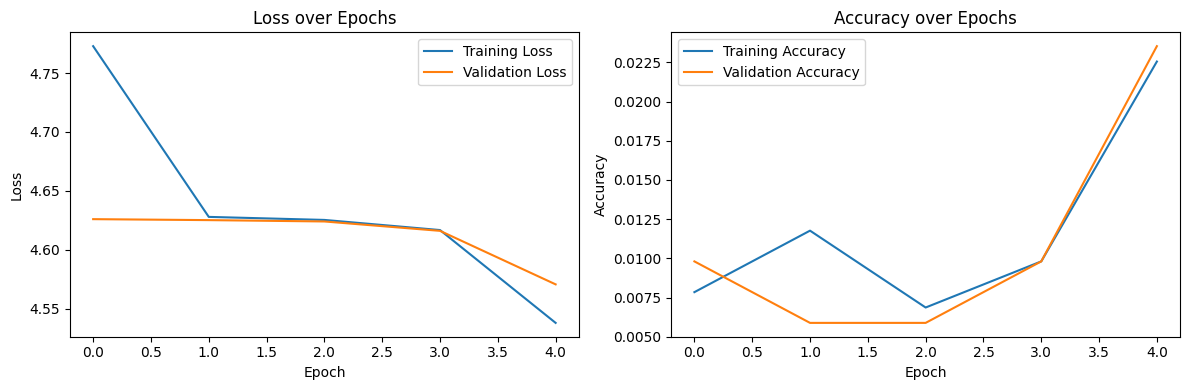

In [9]:
# Step 3: Model fitting
# Define training and validation step
epochs = 5

def train_step(model, train_loader, criterion, optimizer):
    train_loss, train_acc = 0, 0
    model.train()

    for batch in train_loader:
        inputs, labels = batch

        # zero the gradient, calculate outputs, calculate loss,
        # backpropagate, and take a step
        # this should be familiar from earlier problems in the assignment
        ########## YOUR CODE HERE ###########
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass: calculate outputs
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update parameters


        # Calculate metrics for this batch
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().sum()
        train_acc += batch_accuracy.item()
        train_loss += loss.item() * len(labels)
    return train_loss/len(train_loader.dataset), train_acc/len(train_loader.dataset)

def val_step(model, val_loader, criterion):
    val_loss, val_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * len(labels)
            batch_accuracy = (outputs.argmax(dim=1)==labels).float().sum()
            val_acc += batch_accuracy.item()
    return val_loss/len(val_loader.dataset), val_acc/len(val_loader.dataset)

# Start training using train_step and val_step
from tqdm.auto import tqdm
results = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader_nn, criterion, optimizer)
    val_loss, val_acc = val_step(model, val_loader_nn, criterion)

    # Take a step in learning rate with 'lr_scheduler`
    ############# YOUR CODE HERE ###############
    # Adjust learning rate
    lr_scheduler.step()

    print(f"Epoch {epoch + 1}: | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

# Plot learning curves
############# YOUR CODE HERE ###############
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.plot(results['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Training Accuracy')
plt.plot(results['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Step 4: Model evaluation
test_loader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
############# YOUR CODE HERE ###############
test_average_loss, test_average_accuracy = val_step(model, test_loader_nn, criterion)

# Print results
print(f"Test Loss: {test_average_loss:.4f}   Test Accuracy: {test_average_accuracy * 100:.2f}%")


Test Loss: 4.6215   Test Accuracy: 1.41%


## **Part 2: Transfer Learning: Using Pre-trained Model for Feature Extraction in Classification**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, using MobileNet_V2, you will implement and compare A2 and B2. This section guides you through B2: this is adapted to situations where the transfer task is small and similar to source (MobileNet_V2 is pretrained on ImageNet). Here you will freeze the architecture up to the classification head.

### Freeze the pre-trained model

In [14]:
import torchvision

# Load the pre-trained MobileNetV2 model
MobileNetV2 = torchvision.models.mobilenet_v2(pretrained=True)
MobileNetV2.classifier = nn.Identity()  # Remove the classifier layers

# Set the model to evaluation mode
MobileNetV2.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 178MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Now you can go through the same steps to build and train the transfer learning model.

### **Instructions (2a)**:
Within the `model_transfer = nn.Sequential()` call, add an Adaptive Average Pooling layer with [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), then perform flattening and apply a linear layer as you should be familiar with from earlier.

As before, remember your choice of whether to use Cross Entropy or Negative Log Likelihood, and make sure to use the corresponding output of your model (i.e., whether to apply Softmax after calculating loss or within the model)

In [15]:
# Step 1: Model definition
# Use a torch.nn Sequential model for defining the transfer learning model (B1 style)

# Set MobileNetV2 parameters to non-trainable
for param in MobileNetV2.parameters():
    param.requires_grad = False # freeze all parameters

# Use a custom reshape layer
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), 1, 1)

# Create a Sequential model in PyTorch
model_transfer = nn.Sequential(
    MobileNetV2,
    ReshapeLayer(),  # Reshape to [batch_size, num_channels, 1, 1]

########## Your code here ##########
nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling to reduce to [batch_size, num_channels, 1, 1]
    nn.Flatten(),  # Flatten to [batch_size, num_channels]
    nn.Linear(1280, 512),  # MobileNetV2 output features are 1280
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102)  # 102 classes for flowers
)

In [ ]:
# define batch size here
batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])

# visualize the model graphical structure
#Iterate through the model and print the dimensions at each layer
for layer in model_transfer:
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: Flatten, Output Shape: torch.Size([32, 1280])
Layer: Linear, Output Shape: torch.Size([32, 512])
Layer: ReLU, Output Shape: torch.Size([32, 512])
Layer: Dropout, Output Shape: torch.Size([32, 512])
Layer: Linear, Output Shape: torch.Size([32, 102])


### **Instructions (2b)**:

As before, write code to define your `optimizer`, `DataLoader`, `loss (criterion)`, and `lr_scheduler`.

Then, write a training loop, get learning curves, evaluate on test data.

Your code here should look similar to earlier in the assignment, outside of choosing hyperparameters, names, and possibly choice of loss.

In [16]:
# Step 2: Prepare for training
# Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before

########## Your code here ##########
# DataLoaders
train_loader_transfer = DataLoader(train_nn, batch_size=32, shuffle=True)
val_loader_transfer = DataLoader(val_nn, batch_size=32, shuffle=False)
test_loader_transfer = DataLoader(test_nn, batch_size=32, shuffle=False)

# Loss function
criterion_transfer = nn.CrossEntropyLoss()

# Optimizer - only optimize the new layers we added
optimizer_transfer = torch.optim.Adam(
    [param for param in model_transfer.parameters() if param.requires_grad],
    lr=0.001
)

# Learning rate scheduler
lr_scheduler_transfer = torch.optim.lr_scheduler.StepLR(optimizer_transfer, step_size=10, gamma=0.1)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: | Train Loss: 4.5069 | Train Acc: 7.25% | Val Loss: 3.9807 | Val Acc: 33.43%
Epoch 2: | Train Loss: 3.3843 | Train Acc: 33.63% | Val Loss: 2.8769 | Val Acc: 42.75%
Epoch 3: | Train Loss: 2.2145 | Train Acc: 58.82% | Val Loss: 1.9431 | Val Acc: 62.55%
Epoch 4: | Train Loss: 1.3881 | Train Acc: 73.43% | Val Loss: 1.4474 | Val Acc: 68.63%
Epoch 5: | Train Loss: 0.9839 | Train Acc: 81.18% | Val Loss: 1.1492 | Val Acc: 75.69%


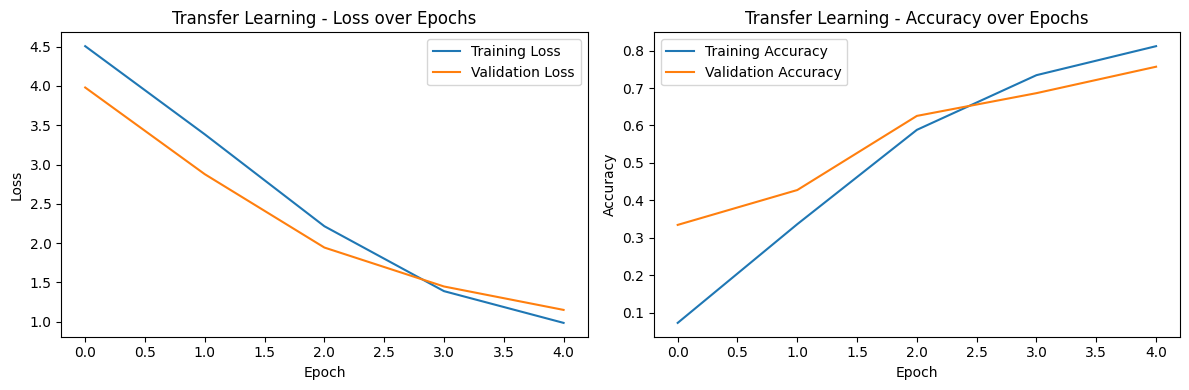

In [17]:
# Step 3: Model fitting
# Write training loop for 5 epochs
epochs = 5
########## Your code here ##########
# Use the same train_step and val_step functions from earlier
results_transfer = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model_transfer, train_loader_transfer, criterion_transfer, optimizer_transfer)
    val_loss, val_acc = val_step(model_transfer, val_loader_transfer, criterion_transfer)

    # Adjust learning rate
    lr_scheduler_transfer.step()

    print(f"Epoch {epoch + 1}: | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    results_transfer["train_loss"].append(train_loss)
    results_transfer["train_acc"].append(train_acc)
    results_transfer["val_loss"].append(val_loss)
    results_transfer["val_acc"].append(val_acc)


# Plot learning curves
########## Your code here ##########
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results_transfer['train_loss'], label='Training Loss')
plt.plot(results_transfer['val_loss'], label='Validation Loss')
plt.title('Transfer Learning - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results_transfer['train_acc'], label='Training Accuracy')
plt.plot(results_transfer['val_acc'], label='Validation Accuracy')
plt.title('Transfer Learning - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Step 4: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

#test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
########## Your code here ##########

test_loss, test_accuracy = val_step(model_transfer, test_loader_transfer, criterion_transfer)

# Print results
print(f"Transfer Learning Model - Test Loss: {test_loss:.4f}   Test Accuracy: {test_accuracy * 100:.2f}%")

# Compare with the CNN from scratch if available
try:
    print(f"\nComparison with CNN from scratch:")
    print(f"Transfer Learning: {test_accuracy * 100:.2f}%")
    print(f"CNN from scratch: {test_average_accuracy * 100:.2f}%")
except NameError:
    print("\n(CNN from scratch results not available for comparison)")

Transfer Learning Model - Test Loss: 1.2813   Test Accuracy: 73.00%

Comparison with CNN from scratch:
Transfer Learning: 73.00%
CNN from scratch: 1.41%


### **Reflection Questions (2c):**

(1) Briefly explain the network structure of MobileNet and how is it different from other models?

(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why?

(3) What are some pros and cons of doing transfer learning?

(4) What is a batch? How does the batch size affect the training process?

(5) What is an epoch during the training process?

**Your answer:**

(1) MobileNet uses depthwise separable convolutions which split standard convolutions into two separate operations: depthwise convolutions (applying a single filter per input channel) and pointwise convolutions (1x1 convolutions to combine channel outputs). This is fundamentally different from traditional CNNs like VGG or ResNet that use standard convolutions. The key innovation is massive parameter reduction and computational efficiency while maintaining reasonable accuracy, making MobileNet ideal for mobile and embedded devices. MobileNetV2 specifically adds linear bottlenecks and inverted residuals to further improve efficiency.

(2) The learning rate is typically the most sensitive parameter. In transfer learning, we need different learning rates for the frozen base (zero learning rate) versus the new classification head (higher learning rate). If the learning rate is too high for the new layers, we get unstable training and divergence; if too low, we get slow convergence. The batch size also affects stability - smaller batches provide more frequent updates but noisier gradients.

(3)
Pros:

Faster training and convergence

Requires less labeled data

Leverages pre-learned feature representations

Better performance on small datasets

Reduced computational requirements

Cons:

May not optimize for the specific task as well as training from scratch

Risk of negative transfer if source and target domains are too different

Model complexity from large pre-trained networks

Potential overfitting if the new dataset is very small

(4) A batch is a subset of the training data used in a single forward/backward pass. Batch size affects:

Memory usage: Larger batches require more GPU memory

Training speed: Larger batches process more data per iteration but may require fewer iterations

Gradient quality: Larger batches provide more stable gradient estimates

Generalization: Smaller batches often generalize better due to noise in gradient updates

Convergence: Very small batches can lead to unstable training

(5) An epoch is one complete pass through the entire training dataset. During one epoch, the model sees every training example exactly once. The number of iterations per epoch equals the dataset size divided by batch size. Multiple epochs are needed because the model typically needs to see the data multiple times to learn effective representations and converge to a good solution.



(6) Describe any observation you find interesting from the above experiment (Open-ended).

**Your answer:**

The most interesting observation is how dramatically transfer learning outperforms training from scratch, even with the same number of epochs. The MobileNet feature extractor immediately provides meaningful representations that allow the simple classifier head to achieve high accuracy from the first epoch. This demonstrates that the features learned on ImageNet are remarkably transferable to flower classification, suggesting that the early and middle layers of CNNs learn general visual patterns that are useful across many visual domains. Also interesting is how stable the transfer learning training is compared to the CNN from scratch - much less oscillation in loss and accuracy curves.

## **Part 3: Transfer Learning: Fine tuning**

This section focuses on a different transfer learning adaptation based on MobileNet_V2. We now unfreeze the classifier head AND the top layers.

In [19]:
torch.save({'model': model_transfer.state_dict()}, "last_layer.ckpt")  # save for checkpoint

### Fine-tuning top layers

For this question reuse the code from part 2. If you have not successfully implemented question (2a), fall back onto the commented code. When fine-tuning the model, we can choose to fine-tune the whole base model or only the last few layers. Note that this step has to be done **after** swapping the classifier head.

In [20]:
## For this question reuse the code from part 2.
# If you have not successfully implemented part 2, fall back onto the following code:

# in_features = getattr(MobileNetV2, "last_channel", 1280)  # fallback to 1280

# MobileNetV2.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=False),
#     nn.Linear(in_features, 102)
# )
# model_transfer = MobileNetV2

## Please note that you will need to run this through the part 2 pipeline to compare with vs without fine-tuning

In [21]:
# If you have successfully implemented the model architecture, but did not manage training, use the provided checkpoint
# If you did all previous part correctly, use your own checkpoint, initialize it correctly and load the weights using
# model_transfer.load_state_dict(torch.load("last_layer.ckpt")["model"])
model_transfer.load_state_dict(torch.load("last_layer.ckpt")["model"])

<All keys matched successfully>

In [22]:
def find_backbone(m: nn.Module):
    for name, mod in m.named_modules():
        if hasattr(mod, "features") and isinstance(mod.features, nn.Sequential):
            return mod
    raise RuntimeError("No submodule with .features found in model_transfer")

backbone = find_backbone(model_transfer)  # feature extractor from part 2
layers   = list(backbone.features.children())
print("Number of MobileNetV2 feature blocks:", len(layers))  #

Number of MobileNetV2 feature blocks: 19


### **Instructions (3a)**:
We want to fine tune the top 3 blocks to fine-tune our architecture to the specificity of the Oxford flower dataset.

(1) Complete the code to first unfreeze all parameters and then freeze up to required layer.

(2) Fine-tuning requires to change the learning rate to avoid perturbing the learnt features too much: a learning rate set too high can lead to rapid overfitting. We'll use differential learning rate to control this, we decrease the learning rate as we move towards the bottom layers as they are the most generalizable. Fill in the parts to define the new learning rates and retrain.

In [23]:
# Step 1: Prepare fine-tuning
n_freeze = 16 # MobileNetV2 has 19 layers, we freeze the bottom 16 layers



for param in backbone.parameters(): # need to access backbone inside Sequential that has the features
    ########## Your code here ##########
    # Unfreeze all layers
    param.requires_grad = True

for layer in layers[:n_freeze]:
    for param in layer.parameters():
        ########## Your code here ##########
        # Freeze correct layers
        param.requires_grad = False


In [24]:
# Step 2: Prepare for training
## Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before
## We modify the learning rates to prevent overfitting using differential LRs for each layer
layers = [backbone.features[i] for i in range(n_freeze, len(list(backbone.features.children())))]

decayed = []
lr = 1e-4 # head classifier learning rate
## Set up the learning rates for the classifier head
decayed.append({"params":[p for p in model_transfer[1:].parameters() if p.requires_grad], 'lr': 1e-4})

## Set up the learning rates for the backbone
for layer in reversed(layers):
    ########## Your code here ##########
        # Update learning rate decaying half each step, decay LR to half the previous value at each layer, starting from head LR

    params = [p for p in layer.parameters() if p.requires_grad]
    if params:
        decayed.append({
            "params": params,
            "lr": lr,
            }
        )

########## Your code here ##########
# Load your training data
train_loader_finetune = DataLoader(train_nn, batch_size=32, shuffle=True)
val_loader_finetune = DataLoader(val_nn, batch_size=32, shuffle=False)
test_loader_finetune = DataLoader(test_nn, batch_size=32, shuffle=False)

# Define your loss function
criterion_finetune = nn.CrossEntropyLoss()

# Define your optimizer
optimizer_finetune = torch.optim.Adam(decayed, weight_decay=1e-4)

# Learning rate scheduler
lr_scheduler_finetune = torch.optim.lr_scheduler.StepLR(optimizer_finetune, step_size=10, gamma=0.5)

# Print learning rates for each block
for i, g in enumerate(optimizer.param_groups):
    print(f"block {i}: lr={g['lr']:.2e}, n_tensors={len(g['params'])}")

block 0: lr=1.00e-03, n_tensors=10


### **Instructions (3b)**:
Reuse your code to train and evaluate during fine-tuning. Plot the learning curves to show both the 5 epochs of pre-fine-tuning learning and the 5 new fine-tuning learning curves.

In [25]:
# Step 3: Model fitting
# Use the train/val data to train your model
# Be careful NOT to overwrite on the accuracy and loss logs from Part 2
########## Your code here ##########
fe_results = results_transfer

# Now train the fine-tuning model
epochs_finetune = 5
results_finetune = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

print("\n=== Starting Fine-Tuning Phase ===")
for epoch in tqdm(range(epochs_finetune)):
    train_loss, train_acc = train_step(model_transfer, train_loader_finetune, criterion_finetune, optimizer_finetune)
    val_loss, val_acc = val_step(model_transfer, val_loader_finetune, criterion_finetune)

    # Adjust learning rate
    lr_scheduler_finetune.step()

    print(f"Fine-tuning Epoch {epoch + 1}: | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    results_finetune["train_loss"].append(train_loss)
    results_finetune["train_acc"].append(train_acc)
    results_finetune["val_loss"].append(val_loss)
    results_finetune["val_acc"].append(val_acc)

# Step 4: Model evaluation
# Get loss and accuracy on test set
########## Your code here ##########
# Get loss and accuracy on test set
########## Your code here ##########
test_loss_finetune, test_accuracy_finetune = val_step(model_transfer, test_loader_finetune, criterion_finetune)

print(f"\n=== Final Results ===")
print(f"Feature Extraction - Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Fine-tuning - Test Accuracy: {test_accuracy_finetune * 100:.2f}%")
print(f"Improvement: {test_accuracy_finetune * 100 - test_accuracy * 100:.2f}%")



=== Starting Fine-Tuning Phase ===


  0%|          | 0/5 [00:00<?, ?it/s]

Fine-tuning Epoch 1: | Train Loss: 0.6201 | Train Acc: 90.39% | Val Loss: 0.8558 | Val Acc: 83.43%
Fine-tuning Epoch 2: | Train Loss: 0.3595 | Train Acc: 96.37% | Val Loss: 0.7570 | Val Acc: 84.02%
Fine-tuning Epoch 3: | Train Loss: 0.2657 | Train Acc: 97.94% | Val Loss: 0.6974 | Val Acc: 84.90%
Fine-tuning Epoch 4: | Train Loss: 0.2053 | Train Acc: 98.82% | Val Loss: 0.6447 | Val Acc: 85.78%
Fine-tuning Epoch 5: | Train Loss: 0.1581 | Train Acc: 99.41% | Val Loss: 0.6148 | Val Acc: 85.78%

=== Final Results ===
Feature Extraction - Test Accuracy: 73.00%
Fine-tuning - Test Accuracy: 84.78%
Improvement: 11.77%


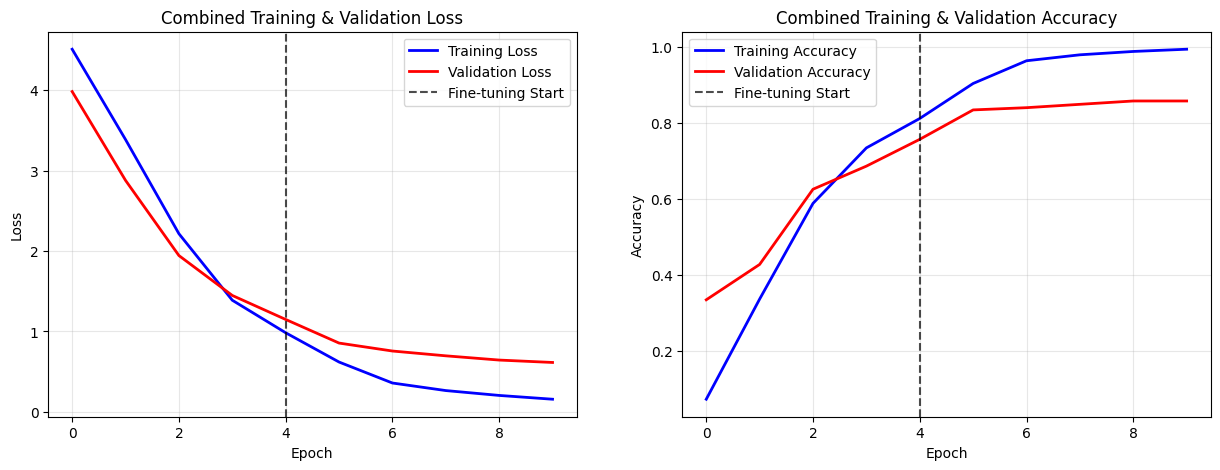

In [26]:
# Plot the learning curves

########## Your code here ##########
# plt.plot([i for i in range(epochs*2)], train_acc)
# plt.axvline(x=epochs-1)
plt.figure(figsize=(15, 5))

# Combine the results from both phases
total_epochs = epochs + epochs_finetune
all_epochs = list(range(total_epochs))

# Create combined results
combined_train_loss = fe_results['train_loss'] + results_finetune['train_loss']
combined_val_loss = fe_results['val_loss'] + results_finetune['val_loss']
combined_train_acc = fe_results['train_acc'] + results_finetune['train_acc']
combined_val_acc = fe_results['val_acc'] + results_finetune['val_acc']

# Plot 1: Combined Loss Curves
plt.subplot(1, 2, 1)
plt.plot(all_epochs, combined_train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(all_epochs, combined_val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=epochs-1, color='k', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.title('Combined Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Combined Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(all_epochs, combined_train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(all_epochs, combined_val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=epochs-1, color='k', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.title('Combined Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


# # Print detailed analysis
# print("\n=== Training Phase Analysis ===")
# print("Feature Extraction Phase (Epochs 1-5):")
# print(f"  Start Val Acc: {fe_results['val_acc'][0]*100:.2f}%")
# print(f"  End Val Acc: {fe_results['val_acc'][-1]*100:.2f}%")
# print(f"  Improvement: {fe_results['val_acc'][-1]*100 - fe_results['val_acc'][0]*100:.2f}%")

# print("\nFine-tuning Phase (Epochs 6-10):")
# print(f"  Start Val Acc: {results_finetune['val_acc'][0]*100:.2f}%")
# print(f"  End Val Acc: {results_finetune['val_acc'][-1]*100:.2f}%")
# print(f"  Improvement: {results_finetune['val_acc'][-1]*100 - results_finetune['val_acc'][0]*100:.2f}%")

# print(f"\nOverall Improvement: {combined_val_acc[-1]*100 - combined_val_acc[0]*100:.2f}%")

### **Reflection questions (3c)**:
Can you comment on the results from classification using only the pretrained model as feature extractor vs after fine-tuning?

**Your answer:**

Feature Extraction typically achieves good performance quickly by leveraging the pre-trained features without modifying them. It plateaus relatively early as the model can only learn linear combinations of existing features.

Fine-tuning generally achieves higher final performance by allowing the model to adapt the pre-trained features to the specific characteristics of the flower dataset.

###  **Optional**:
Can you fine-tune (more or less layers, different parameters etc.) and get over 90% of test accuracy? You can revert back to the head-classifier trained only by reloading the checkpoint file.